# 2. Multi object detection

This notebook is motivated by fast.ai's course.

In [1]:
%matplotlib inline
# % load_ext autoreload
# % autoreload 2

In [2]:
import torch
import voc
from pathlib import Path

import numpy as np
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

### 1. Defining the datasets

The dataset objects take as input a mask, which allow me to split the data into training and validation data.

In [4]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [5]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [6]:
train_images = voc.datasets.MultiImageDataset(mask=train_mask, normalizer='imagenet', 
                                         random_transform=True, resize=(224, 224), device=device)

In [7]:
label2class = train_images.get_labels_from_classes()
normalizer = train_images.get_normalizer()
class2label = {int(im_class): label for label, im_class in label2class.items()}

In [8]:
val_images = voc.datasets.MultiImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [9]:
im, bbs, labs = train_images.__getitem__(10)

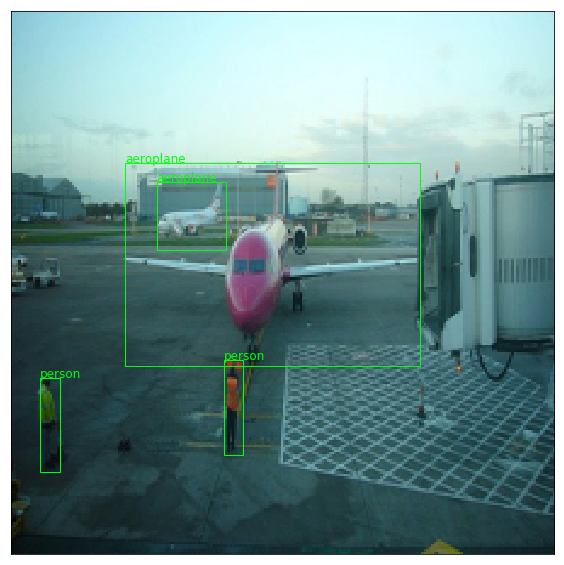

In [10]:
txt_labs = [class2label[idx.item()] for idx in labs]
denormed_im = voc.utils.denormalize(im.cpu().numpy(), mean=normalizer['mean'], std=normalizer['std'])
voc.explore.plot_image(denormed_im, bbs.cpu().numpy(), txt_labs)

Awesome. Now, in order to figure out which activations should find each of these objects, I need to do the following:

- Figure out what my **base** anchor boxes are going to be.
- Figure out what my **permuted** anchor boxes are going to be.

Then,

- Assign each ground truth bounding box to a **permuted** bounding box anchor

### 2.1. Getting the base bounding boxes

I am going to do this across 3 'depths', but I'll only visualize the `2 x 2` activations, to prevent the overlap from being confusing.

I'll start by considering an image of size `(1, 1)`, which I can then multiply by 224 to reflect the resnet-processed images.

In [9]:
import numpy as np

In [10]:
anchors_4 = voc.utils.make_anchors(224, 224, 0.25)
anchors_2 = voc.utils.make_anchors(224, 224, 0.5)
anchors_1 = voc.utils.make_anchors(224, 224, 1)

anchors = np.vstack((anchors_4, anchors_2, anchors_1))

Lets plot these bounding boxes, to see what they look like

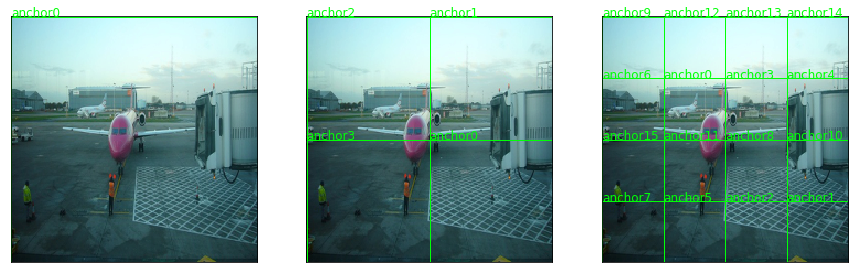

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

voc.explore.plot_image(denormed_im, anchors_1, labels=['anchor' + str(i) for i in range(len(anchors_1))], ax=ax[0])
voc.explore.plot_image(denormed_im, anchors_2, labels=['anchor' + str(i) for i in range(len(anchors_2))], ax=ax[1])
voc.explore.plot_image(denormed_im, anchors_4, labels=['anchor' + str(i) for i in range(len(anchors_4))], ax=ax[2])

Lets take a look at what these permuted anchors look like for the `2x2` boxes:

### 2.2. Permuting the base bounding boxes

In [15]:
pm_anc_2, num_permutations = voc.utils.permute_anchors(anchors_2, zooms=[1.3, 1., 0.7], 
                                                       ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

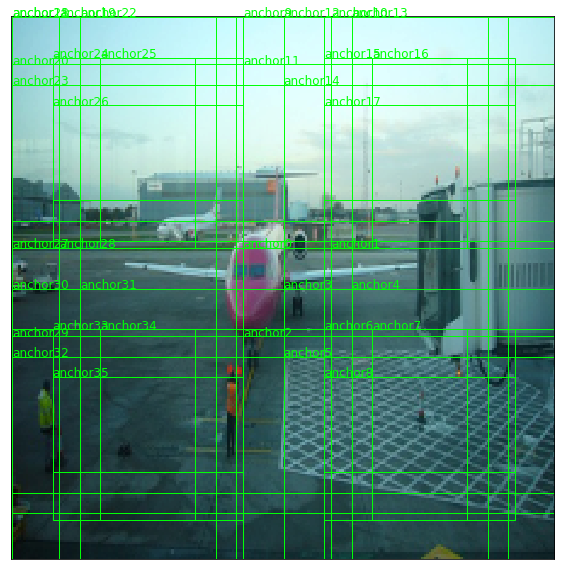

In [16]:
voc.explore.plot_image(denormed_im, pm_anc_2, labels=['anchor' + str(i) for i in range(len(pm_anc_2))])

Now, for all the boxes:

In [11]:
pm_anc, num_permutations = voc.utils.permute_anchors(anchors, zooms=[0.7, 1, 1.3], 
                                                     ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

In [12]:
num_permutations

9

In [13]:
pm_anc_tensor = torch.from_numpy(pm_anc).float().cuda()

Now that I have defined these anchor boxes, I can find the best learning rate for my model

### 3. Getting the minimum and maximum learning rates, and defining a scheduler

In [14]:
criterion = voc.models.SSDLoss(anchors=pm_anc_tensor, threshold=0.4, num_classes=len(label2class), device=device)

In [15]:
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

starting_learning_rate = 1e-5
ending_learning_rate = 1

total_loss = []
learning_rate_progression = []

test_dataloader = DataLoader(train_images, batch_size=64, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)
parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    
        addition = (batch_number / len(test_dataloader)) * (ending_learning_rate - starting_learning_rate)
        learning_rate = starting_learning_rate + addition
        # create a new optimizer with higher learning rates
        optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = test_ssd(ims)
        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + label_loss
        learning_rate_progression.append(learning_rate)
        total_loss.append(loss)
        loss.backward()
        optimizer.step()

100%|██████████| 63/63 [01:44<00:00,  1.65s/it]


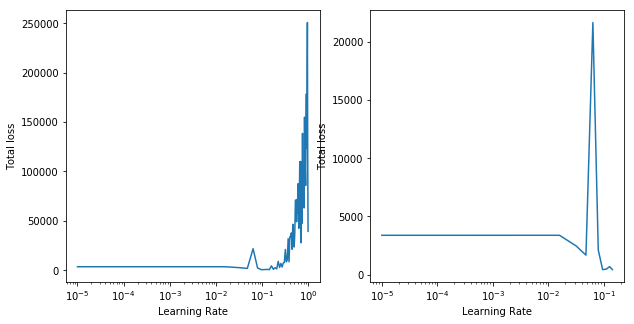

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(learning_rate_progression, total_loss)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(learning_rate_progression[:10], total_loss[:10])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

In [15]:
min_lr = 1e-5
max_lr = 1e-2

Now, we can define our model, and our optimizer

In [16]:
ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

In [17]:
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)
val_dataloader = DataLoader(val_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [18]:
stepsize = int(len(train_dataloader) + 1 / 2)

In [19]:
parameters_to_update = [parameters for name, parameters in ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)

In [20]:
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

In [24]:
lr_change = cl_scheduler.test()

Text(0,0.5,'Learning rate')

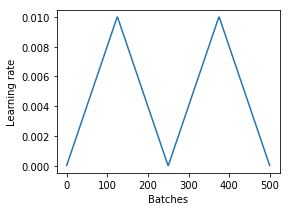

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(len(lr_change)), lr_change)
ax.set_xlabel('Batches')
ax.set_ylabel('Learning rate')

### 4. Training a model

In [21]:
num_epochs = 100
patience = 5
best_val_loss = np.inf
patience_counter = 0

In [22]:
for epoch in range(num_epochs):
    # set model to train
    ssd.train()

    # Keep track of my loss, so I can display it
    running_train_scores = defaultdict(list)
    
    # Iterate through my batches
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = ssd(ims)

        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + label_loss
        loss.backward()
        optimizer.step()
        # For display purposes:
        running_train_scores['loss'].append(loss.item())
        running_train_scores['bb_loss'].append(bb_loss.item())
        running_train_scores['label_loss'].append(label_loss.item())
        # note that the step happens every batch, not every epoch
        cl_scheduler.step()

    train_output_strings = []
    for key, val in running_train_scores.items():
        train_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))

    # now, lets see how we did on the validation set
    if val_dataloader:
        ssd.eval()
        running_val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in (enumerate(val_dataloader)):
                val_ims, val_bb, val_lab = batch
                output_bb, output_labels = ssd(val_ims)
                val_bb_loss, val_label_loss = criterion(val_bb, val_lab, output_bb, output_labels)
                val_loss = val_bb_loss + val_label_loss
                running_val_scores['loss'].append(val_loss)
                running_val_scores['bb_loss'].append(val_bb_loss)
                running_val_scores['label_loss'].append(val_label_loss)
                
            # early stopping
            total_val_loss = np.array(running_val_scores['loss']).mean()
            if total_val_loss < best_val_loss:
                print('Saving model')
                best_val_loss = total_val_loss
                patience_counter = 0
                model_information = {
                    'state_dict': ssd.state_dict()
                }
                torch.save(model_information, 'ssd.pth.tar')
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print('Early stopping')
                    break
            
        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

100%|██████████| 125/125 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 170.30806, bb_loss: 3.23887, label_loss: 167.06919
VALIDATION: loss: 16.09449005126953, bb_loss: 3.180619955062866, label_loss: 12.913880348205566


100%|██████████| 125/125 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 17.16789, bb_loss: 3.37956, label_loss: 13.78833
VALIDATION: loss: 14.71300983428955, bb_loss: 2.9674999713897705, label_loss: 11.74551010131836


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 16.19406, bb_loss: 3.2253, label_loss: 12.96876
VALIDATION: loss: 14.874759674072266, bb_loss: 3.1013600826263428, label_loss: 11.77340030670166


100%|██████████| 125/125 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 15.87523, bb_loss: 3.20763, label_loss: 12.66761
VALIDATION: loss: 13.675270080566406, bb_loss: 2.8796799182891846, label_loss: 10.7955904006958


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 15.2033, bb_loss: 3.12127, label_loss: 12.08203
VALIDATION: loss: 14.187780380249023, bb_loss: 3.009779930114746, label_loss: 11.178000450134277


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 15.30942, bb_loss: 3.13062, label_loss: 12.1788
VALIDATION: loss: 13.247200012207031, bb_loss: 2.9014999866485596, label_loss: 10.34570026397705


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 14.72184, bb_loss: 3.08511, label_loss: 11.63674
VALIDATION: loss: 13.9302396774292, bb_loss: 2.9827098846435547, label_loss: 10.947529792785645


100%|██████████| 125/125 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 14.8242, bb_loss: 3.10733, label_loss: 11.71687
VALIDATION: loss: 12.824370384216309, bb_loss: 2.8610999584198, label_loss: 9.96325969696045


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 14.32304, bb_loss: 3.04204, label_loss: 11.281
VALIDATION: loss: 13.4722900390625, bb_loss: 3.0279901027679443, label_loss: 10.444290161132812


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 14.45014, bb_loss: 3.05174, label_loss: 11.3984
VALIDATION: loss: 12.582460403442383, bb_loss: 2.8274600505828857, label_loss: 9.755009651184082


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 13.87693, bb_loss: 2.98048, label_loss: 10.89645
VALIDATION: loss: 13.24347972869873, bb_loss: 2.889539957046509, label_loss: 10.3539400100708


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 14.02903, bb_loss: 3.02409, label_loss: 11.00494
VALIDATION: loss: 12.411609649658203, bb_loss: 2.7676498889923096, label_loss: 9.643959999084473


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 13.56334, bb_loss: 2.944, label_loss: 10.61935
VALIDATION: loss: 13.083040237426758, bb_loss: 2.8541100025177, label_loss: 10.228930473327637


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 13.7224, bb_loss: 2.96764, label_loss: 10.75476
VALIDATION: loss: 12.178000450134277, bb_loss: 2.72121000289917, label_loss: 9.45678997039795


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 13.36219, bb_loss: 2.89862, label_loss: 10.46356
VALIDATION: loss: 12.745809555053711, bb_loss: 2.8004000186920166, label_loss: 9.945409774780273


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 13.44972, bb_loss: 2.92558, label_loss: 10.52414
VALIDATION: loss: 12.058629989624023, bb_loss: 2.6971800327301025, label_loss: 9.361459732055664


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.97091, bb_loss: 2.86274, label_loss: 10.10817
VALIDATION: loss: 12.59214973449707, bb_loss: 2.7878899574279785, label_loss: 9.80426025390625


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 13.18921, bb_loss: 2.88148, label_loss: 10.30773
VALIDATION: loss: 11.914910316467285, bb_loss: 2.65054988861084, label_loss: 9.264360427856445


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.76769, bb_loss: 2.82272, label_loss: 9.94497
VALIDATION: loss: 12.85925006866455, bb_loss: 2.795370101928711, label_loss: 10.06387996673584


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.99132, bb_loss: 2.85008, label_loss: 10.14124
VALIDATION: loss: 11.82699966430664, bb_loss: 2.6155900955200195, label_loss: 9.211409568786621


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.50256, bb_loss: 2.80051, label_loss: 9.70205
VALIDATION: loss: 12.458780288696289, bb_loss: 2.750849962234497, label_loss: 9.707929611206055


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.86232, bb_loss: 2.82221, label_loss: 10.04011
VALIDATION: loss: 11.694840431213379, bb_loss: 2.5757100582122803, label_loss: 9.119139671325684


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.48554, bb_loss: 2.77383, label_loss: 9.71171
VALIDATION: loss: 12.412030220031738, bb_loss: 2.7222299575805664, label_loss: 9.689800262451172


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.62483, bb_loss: 2.81598, label_loss: 9.80885
VALIDATION: loss: 11.74098014831543, bb_loss: 2.5681800842285156, label_loss: 9.172789573669434


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.24333, bb_loss: 2.7563, label_loss: 9.48703
VALIDATION: loss: 12.376440048217773, bb_loss: 2.658519983291626, label_loss: 9.717920303344727


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.50077, bb_loss: 2.78187, label_loss: 9.7189
VALIDATION: loss: 11.649020195007324, bb_loss: 2.5709800720214844, label_loss: 9.07804012298584


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.12908, bb_loss: 2.74125, label_loss: 9.38783
VALIDATION: loss: 12.56171989440918, bb_loss: 2.6180100440979004, label_loss: 9.943710327148438


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.35771, bb_loss: 2.75563, label_loss: 9.60208
VALIDATION: loss: 11.570799827575684, bb_loss: 2.516590118408203, label_loss: 9.054220199584961


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.01114, bb_loss: 2.71013, label_loss: 9.30101
VALIDATION: loss: 12.657059669494629, bb_loss: 2.684920072555542, label_loss: 9.972140312194824


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.32134, bb_loss: 2.73007, label_loss: 9.59128
VALIDATION: loss: 11.572890281677246, bb_loss: 2.508929967880249, label_loss: 9.063960075378418


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.86595, bb_loss: 2.67047, label_loss: 9.19549
VALIDATION: loss: 12.51200008392334, bb_loss: 2.657589912414551, label_loss: 9.854419708251953


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.33842, bb_loss: 2.73403, label_loss: 9.60438
VALIDATION: loss: 11.547619819641113, bb_loss: 2.4808599948883057, label_loss: 9.066749572753906


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.84453, bb_loss: 2.66449, label_loss: 9.18005
VALIDATION: loss: 12.41841983795166, bb_loss: 2.657589912414551, label_loss: 9.76082992553711


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.28174, bb_loss: 2.70541, label_loss: 9.57633
VALIDATION: loss: 11.618659973144531, bb_loss: 2.4751598834991455, label_loss: 9.143489837646484


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.74851, bb_loss: 2.63237, label_loss: 9.11614
VALIDATION: loss: 12.427519798278809, bb_loss: 2.5830600261688232, label_loss: 9.844459533691406


100%|██████████| 125/125 [01:46<00:00,  1.17it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.18163, bb_loss: 2.69151, label_loss: 9.49012
VALIDATION: loss: 11.453590393066406, bb_loss: 2.4384400844573975, label_loss: 9.01515007019043


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.73455, bb_loss: 2.62674, label_loss: 9.10781
VALIDATION: loss: 12.14501953125, bb_loss: 2.5518999099731445, label_loss: 9.593130111694336


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.96738, bb_loss: 2.68501, label_loss: 9.28237
VALIDATION: loss: 11.534279823303223, bb_loss: 2.4568099975585938, label_loss: 9.077469825744629


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.63967, bb_loss: 2.61119, label_loss: 9.02848
VALIDATION: loss: 12.25100040435791, bb_loss: 2.5993599891662598, label_loss: 9.651639938354492


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 12.01267, bb_loss: 2.65558, label_loss: 9.35709
VALIDATION: loss: 11.415940284729004, bb_loss: 2.442239999771118, label_loss: 8.973690032958984


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.52283, bb_loss: 2.60974, label_loss: 8.91309
VALIDATION: loss: 12.280019760131836, bb_loss: 2.5645198822021484, label_loss: 9.715499877929688


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.96815, bb_loss: 2.66792, label_loss: 9.30023
VALIDATION: loss: 11.449000358581543, bb_loss: 2.429029941558838, label_loss: 9.019969940185547


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.55834, bb_loss: 2.60056, label_loss: 8.95778
VALIDATION: loss: 12.378419876098633, bb_loss: 2.5258400440216064, label_loss: 9.85258960723877


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 11.78649, bb_loss: 2.64992, label_loss: 9.13657
VALIDATION: loss: 11.50790023803711, bb_loss: 2.4257800579071045, label_loss: 9.082119941711426


100%|██████████| 125/125 [01:47<00:00,  1.17it/s]


Early stopping


### 5. Taking a look at the results

In [23]:
imagenet = train_images.get_normalizer()

In [24]:
model = torch.load('ssd.pth.tar')
trained_model = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()
trained_model.load_state_dict(model['state_dict'])

In [25]:
trained_model.eval();

In [26]:
val_ims, bbs, labels = next(iter(val_dataloader))

In [27]:
with torch.no_grad():
    output_bb, output_labels = trained_model(val_ims)

In [28]:
bb_to_plot = output_bb[:10]
lab_to_plot = output_labels[:10]
im_to_plot = val_ims[:10].detach().cpu().numpy()

In [29]:
denormed_ims = [voc.utils.denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

There are two ways results can be plotted; all bounding boxes with a score above a certain threshold can be plotted:

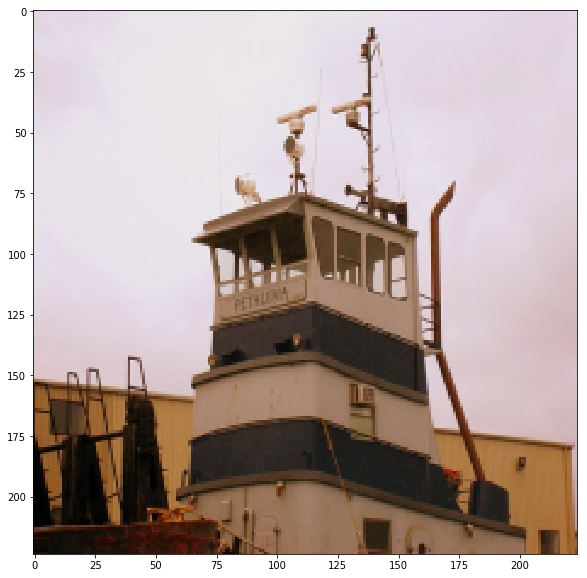

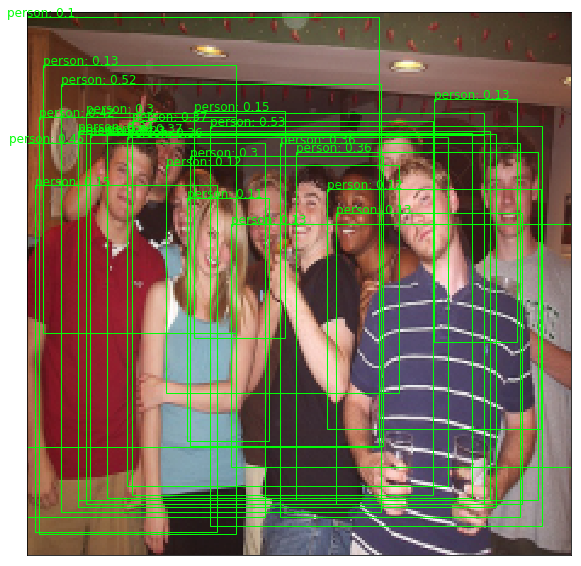

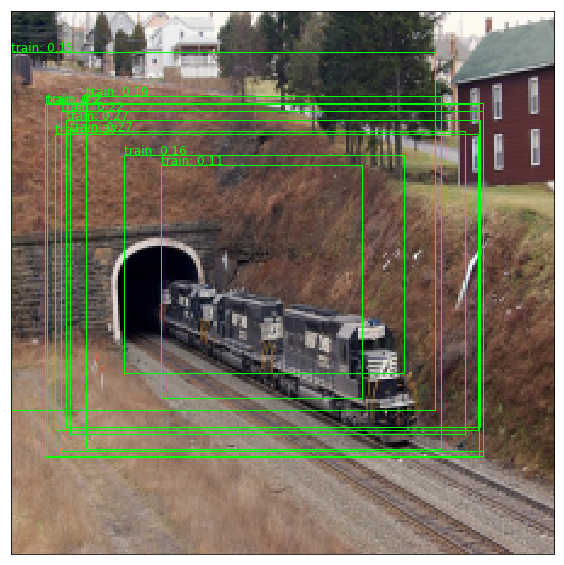

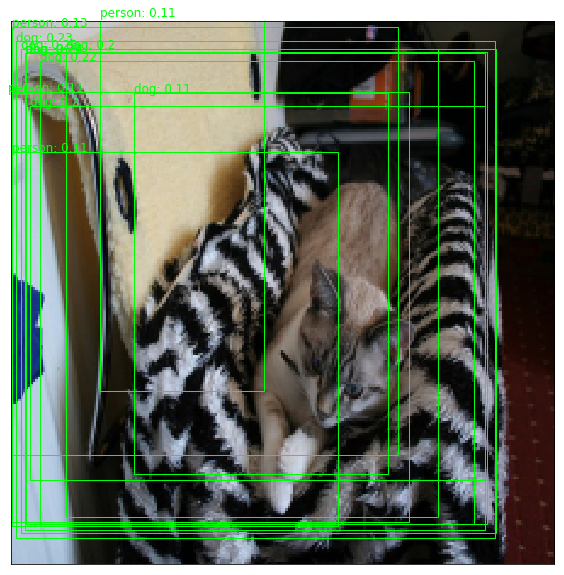

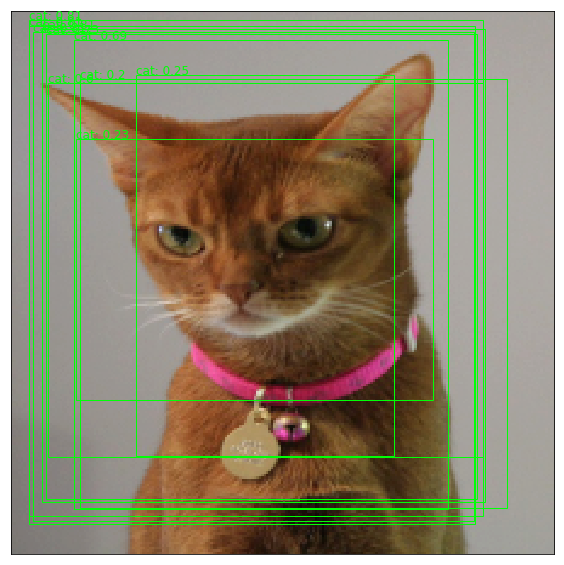

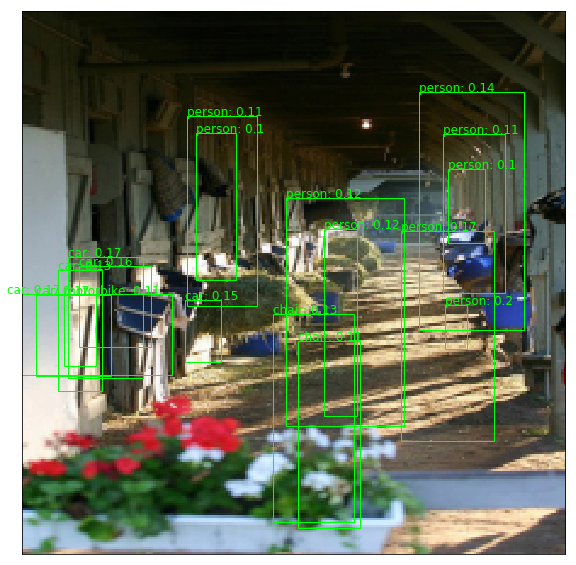

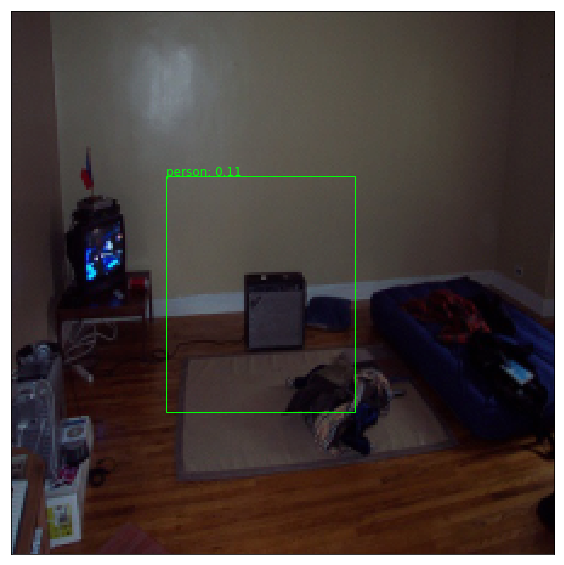

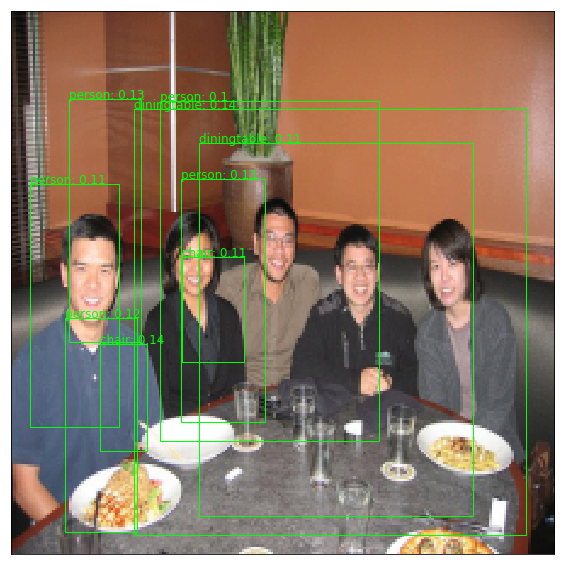

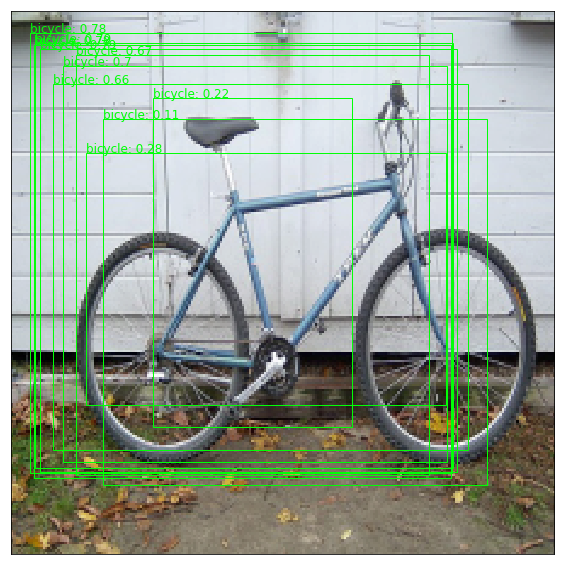

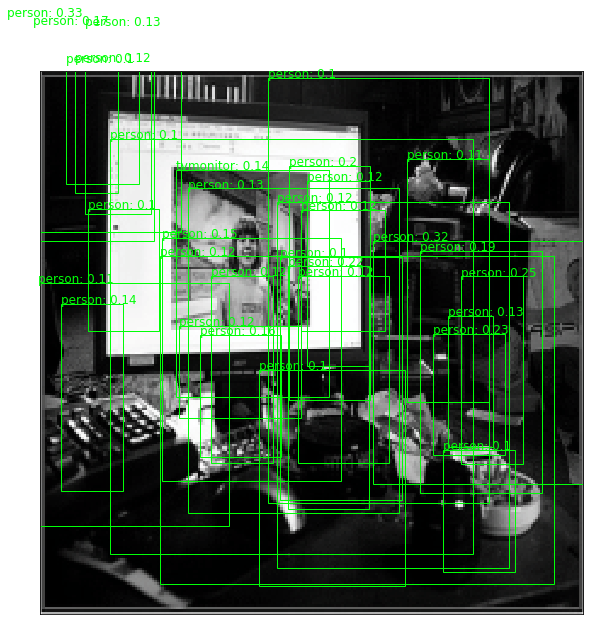

In [30]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.1, use_nms=False)

But this leads to a ton of overlap. A better thing to do is to take all the bounding boxes with a score above a certain threshold, and then - for all of the overlapping boxes - only take the box which the model was most confident about.

This approch is known as non maximum suppression (NMS) (hence the `use_nms=False` argument in the above cell).

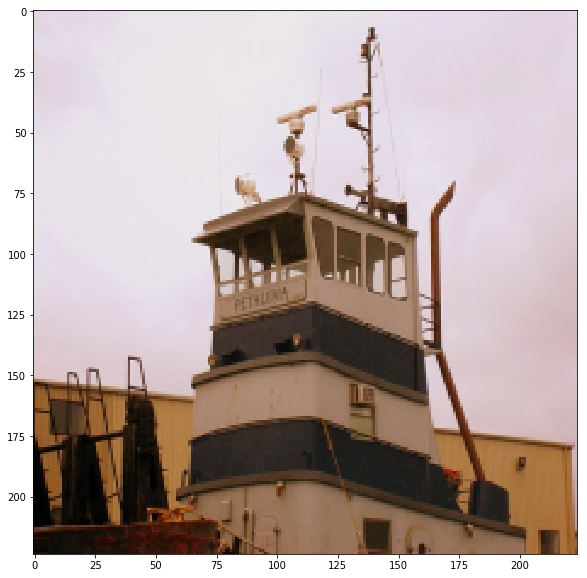

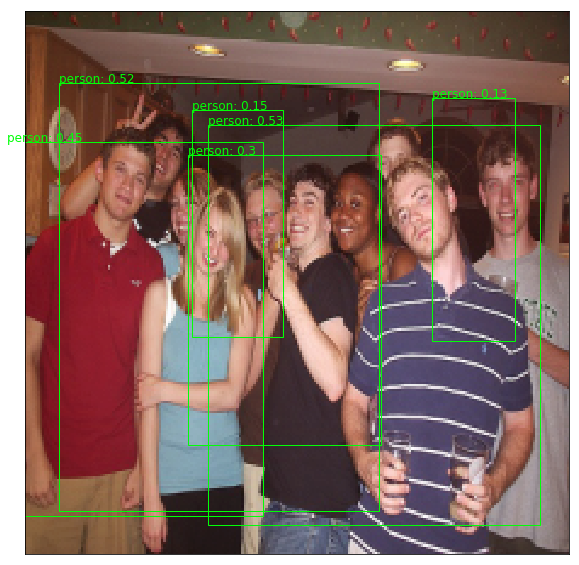

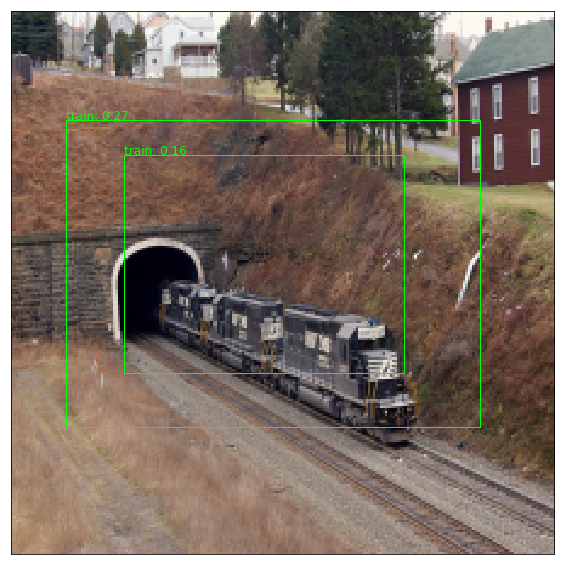

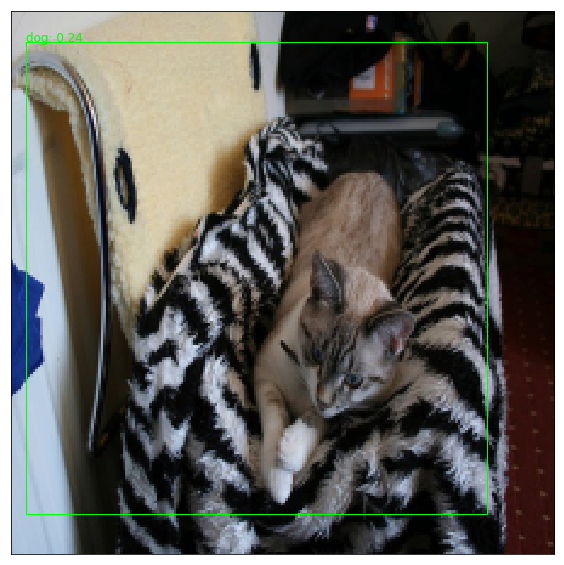

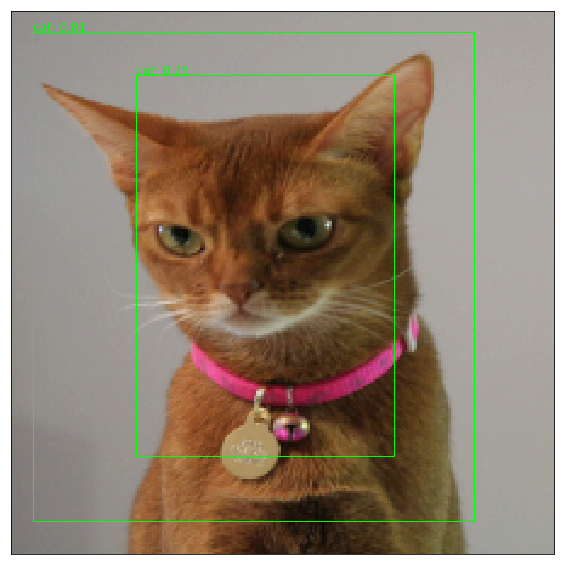

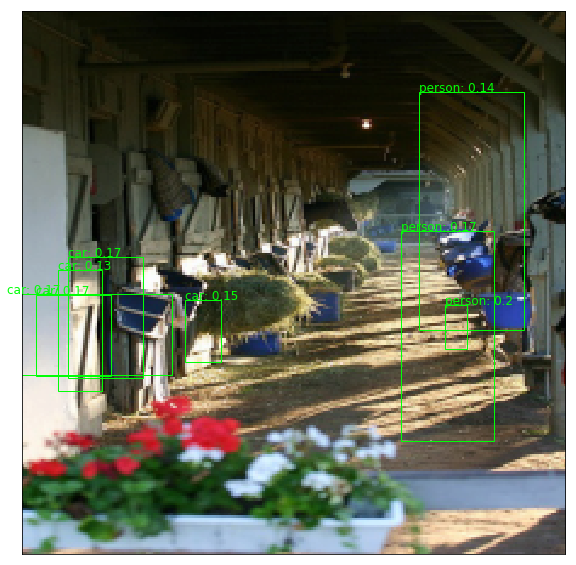

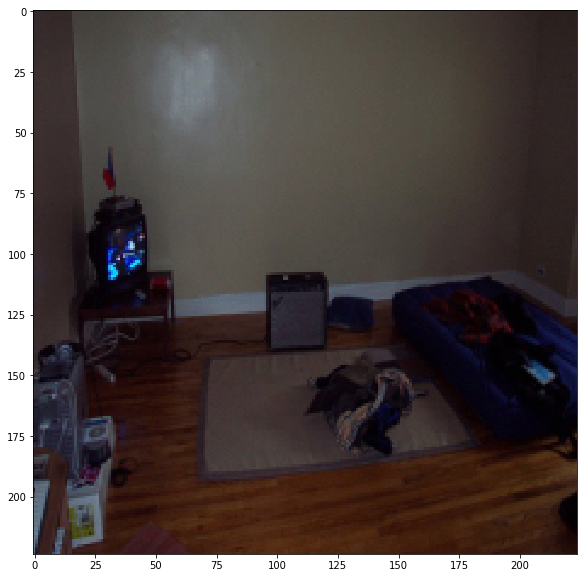

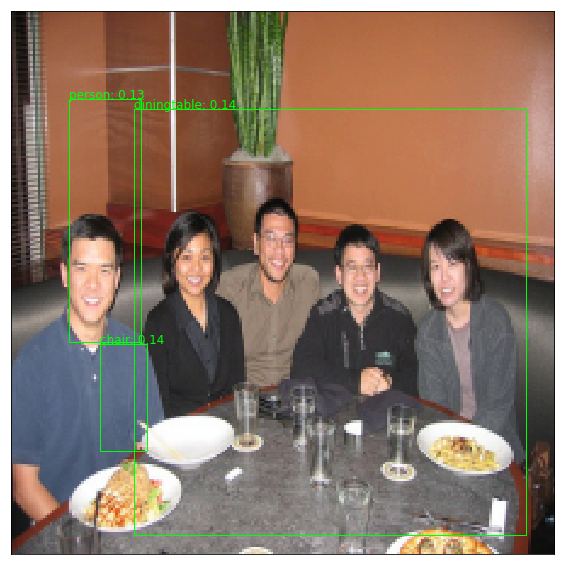

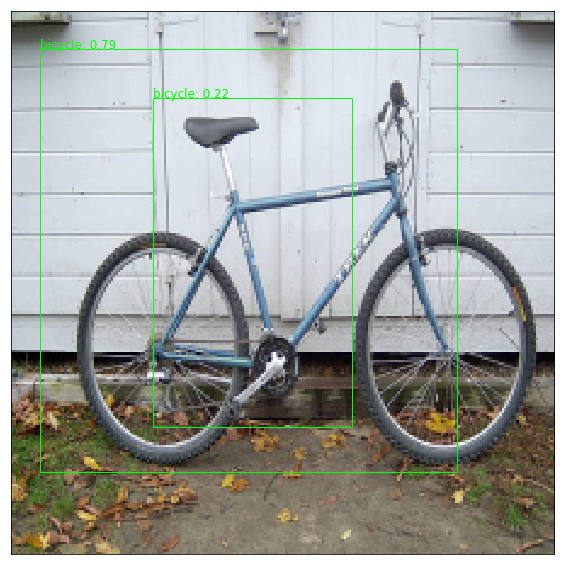

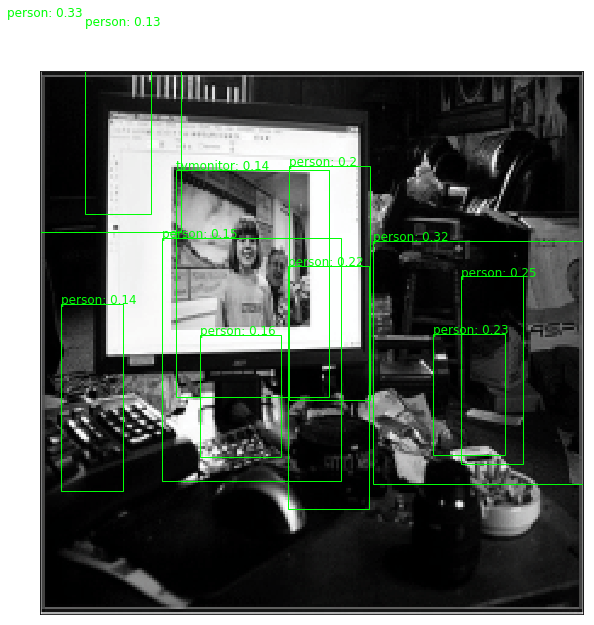

In [31]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.13)